# Rotten Tomatoes Logistic Regression: Supplemental Analysis



In [48]:
# pandas
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt

Get train & test csv files as a DataFrame

In [49]:
sentiment_train_df = pd.read_csv(filepath_or_buffer="train.tsv", sep='\t')

We split the data into 90% train data, 10% test data. We split by movie review ID (SentenceID) to ensure that all movie reviews and their fragments were either in the test or train data but not both.

In [50]:
def Create_Test_Train_Split(train_df, random_seed=42):
    random.seed(random_seed)
    split_size = 0.9

    total_sentences = max(train_df['SentenceId'])
    total_range = range(1,total_sentences + 1,1)
    test_split = int(total_sentences*split_size)
    test_list = random.sample(range(1,total_sentences+1),test_split)
    train_list = set(total_range).difference(set(test_list))

    train_data = train_df.loc[train_df.SentenceId.isin(test_list)]
    test_data = train_df.loc[train_df.SentenceId.isin(train_list)]

    print ('Training set   : {0} data points'.format(len(train_data)))
    print ('Test set       : {0} data points'.format(len(test_data)))
    
    return train_data, test_data

# Supplemental Word Count Analysis

Just for fun, let's take a look at some analysis of word counts and distributions in the train and test sets.

First up, let's build a distribution of movie review (Phrase) lengths in the test set. Note that we have some rows where word count = 0. That is because we are using the same regular expression that we used to tokenize the data to count words. This particular regular expression eliminates tokens of length one, e.g, "a", "I".

In [51]:
train_data, test_data = Create_Test_Train_Split(sentiment_train_df)

Training set   : 140143 data points
Test set       : 15917 data points


In the logistic regression model we use the default regular expression (**r'(?u)\b\w\w+\b'**) to tokenize the data. This regular expression strips out punctuation and single character tokens like "a" and "I." To perform our analysis we will first create a new Phrase column called "Phrase_clean" to hold the Phrase data after it is run through the regular expression. Then we will build our word counts and distributions from that new column.

In [52]:
#Create a new 'Phrase_clean' column to hold cleaned-up phrases
test_data = test_data.assign(Phrase_clean = test_data['Phrase'] \
                                       .str.lower() \
                                       .apply(lambda x: re.findall(r'(?u)\b\w\w+\b', x)) \
                                       .apply(lambda x: " ".join(x)))

train_data = train_data.assign(Phrase_clean = train_data['Phrase'] \
                                       .str.lower() \
                                       .apply(lambda x: re.findall(r'(?u)\b\w\w+\b', x)) \
                                       .apply(lambda x: " ".join(x)))

In [53]:
#Create a new 'word_count' column to hold the word counts
test_data = test_data.assign(word_count = test_data['Phrase_clean'] \
                                       .str.split() \
                                        .apply(lambda x: len(x)))

train_data = train_data.assign(word_count = train_data['Phrase_clean'] \
                                       .str.split() \
                                        .apply(lambda x: len(x)))

In [54]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_clean,word_count
0,1,1,A series of escapades demonstrating the adage ...,1,series of escapades demonstrating the adage th...,33
1,2,1,A series of escapades demonstrating the adage ...,2,series of escapades demonstrating the adage th...,13
2,3,1,A series,2,series,1
3,4,1,A,2,,0
4,5,1,series,2,series,1


Now let's build our phrase length distribution for the test_data set

In [55]:
#Determine length of 'Phrase' column for each row in DataFrame
#Sum counts of row lengths and create Series of results
ser_phrase_len = test_data['word_count'].value_counts(normalize=True)

#Create DataFrame from Series and rename columns
#We need to do this to turn index of Series into a column where data can be accessed
test_phrase_len = pd.DataFrame(ser_phrase_len).reset_index()
test_phrase_len = test_phrase_len.rename(columns={'index':'len_phrase', 'word_count':'distribution'})
test_phrase_len = test_phrase_len.sort_values(by='len_phrase')
test_phrase_len.head()

,len_phrase,distribution
33,0,0.000817
2,1,0.120123
0,2,0.180750
1,3,0.137903
3,4,0.093673


Now let's build a bar chart to display the phrase length distributions. And we'll do it xkcd style just because we can.

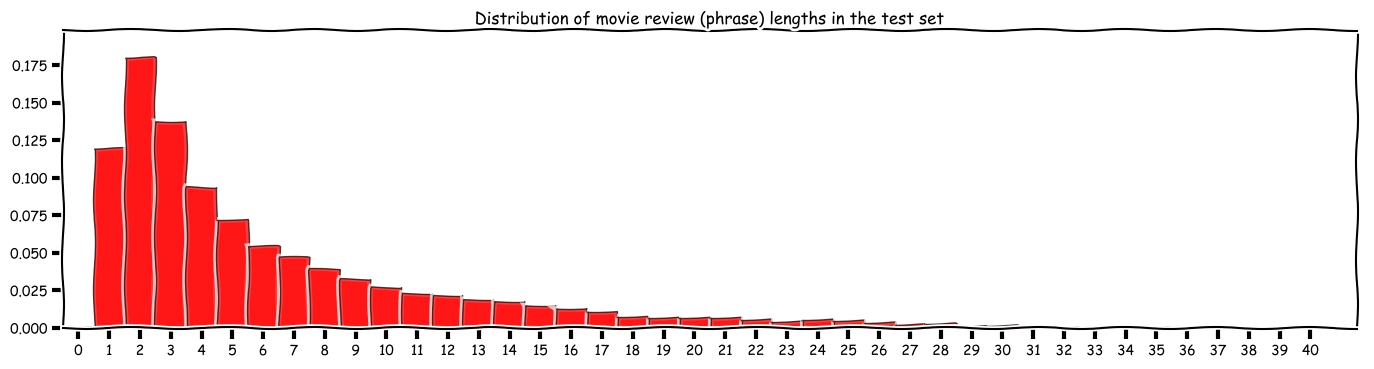

In [56]:
with plt.xkcd():

  #It's easier to set the X axis ticks precisely if we use a bar chart instead of a histogram
  #We need to create an axes object to set the X axis ticks, which is why we use fig, ax = plt.subplots
  fig, ax = plt.subplots(figsize=(14,4))

  y = test_phrase_len['distribution'] 
  N = len(y)
  x = np.arange(0,N)
  width = 1.

  ax.bar(x, y, width, facecolor='red', edgecolor='black', linewidth=1, alpha=0.7)
  ax.set_title('Distribution of movie review (phrase) lengths in the test set')
  ax.set_xlim(0,N+1)
  ax.set_ylim(0, max(y)*1.1)
  ax.set_xticks(x + width/2.) #We need to use this to set the ticks in the middle of each bar
  ax.set_xticklabels(x)

  plt.tight_layout()
  #plt.xkcd()
  plt.rcdefaults()
  plt.show()

Now let's create a list of unique words in the test set and calculate the distribution of their frequencies.

In [57]:
#Create a Counter object to count the number of unique words in the test_data set
results = Counter()
a = test_data['Phrase_clean'].str.split().apply(results.update)

#Create a DataFrame from the Counter object
#Tell the DataFrame to create a new index for the data. Otherwise, the 'word' column will be the index of the DF
#Show a snippet of the results
test_results = pd.DataFrame.from_dict(results, orient='index').reset_index()
test_results = test_results.rename(columns={'index':'word', 0:'count'})
test_results.head()

,word,count
0,belly,14
1,developed,20
2,murderer,7
3,continuity,6
4,ritchie,9


To be safe let's confirm that the test_results DataFrame has no duplicate records.

In [58]:
test_results[(test_results.duplicated('word')==True)]

,word,count


In [59]:
#We want to know the distribution of word count frequencies in the test set
#To do that we can use the value_counts method with the normalize=True parameter to build a series
#of counts by the 'count' column. We then convert the series to a DataFrame and change the series index
#to a DataFrame column. Since the word count distribution has a very long tail we (somewhat arbitrarily)
#limit the DataFrame to the first 30 word count values. To make the plotting easier we sort the DataFrame
#by word count and then rename the columns for greater clarity.

ser_test = test_results['count'].value_counts(normalize=True)
df_test = ser_test.to_frame().reset_index()
df_test = df_test[df_test['index']<=30]
df_test = df_test.sort_values(by='index')
df_test = df_test.rename(columns={'index':'word_count', 'count':'distribution'})
df_test.head()

,word_count,distribution
18,1,0.012601
17,2,0.015454
11,3,0.026866
7,4,0.052306
5,5,0.063481


Now we can build a bar chart that shows the distribution of word frequencies in the test set

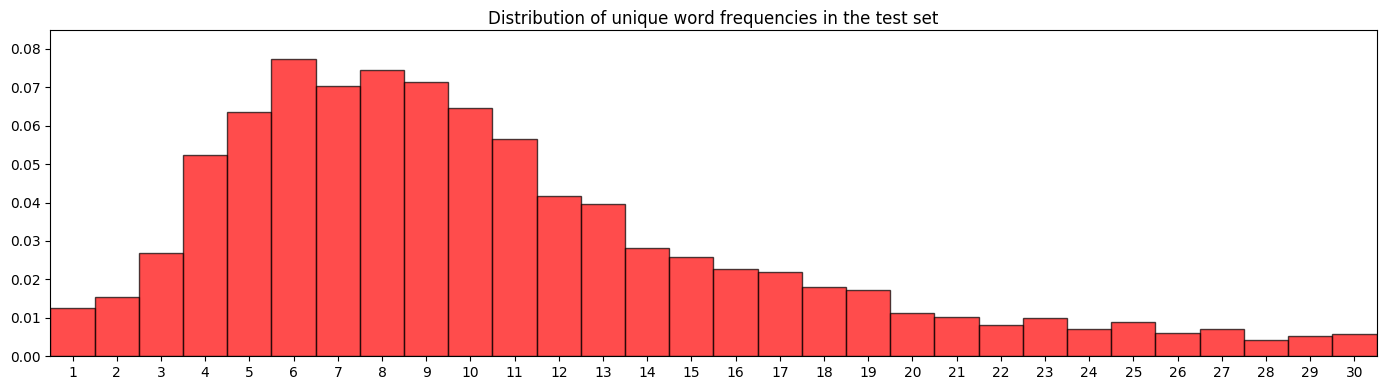

In [60]:
#It's easier to set the X axis ticks precisely if we use a bar chart instead of a histogram
#We need to create an axes object to set the X axis ticks, which is why we use fig, ax = plt.subplots
fig, ax = plt.subplots(figsize=(14,4))

y = df_test['distribution'] 
N = len(y)
x = np.arange(1,N+1)
width = 1.

ax.bar(x, y, width, facecolor='red', edgecolor='black', linewidth=1, alpha=0.7)
ax.set_title('Distribution of unique word frequencies in the test set')
ax.set_xlim(1,N+1)
ax.set_ylim(0, max(y)*1.1)
ax.set_xticks(x + width/2.) #We need to use this to set the ticks in the middle of each bar
ax.set_xticklabels(x)

plt.tight_layout()
plt.show()


Let's repeat the word frequencies analysis for the train set

In [61]:
#Create a Counter object to count the number of unique words in the test_data set
results = Counter()
a = train_data['Phrase_clean'].str.split().apply(results.update)

#Create a DataFrame from the Counter object
#Tell the DataFrame to create a new index for the data. Otherwise, the 'word' column will be the index of the DF
#Show a snippet of the results
train_results = pd.DataFrame.from_dict(results, orient='index').reset_index()
train_results = train_results.rename(columns={'index':'word', 0:'count'})
train_results.head()

,word,count
0,form,134
1,contest,37
2,un,25
3,angst,66
4,just,1600


Next, what we want to know is how many words are unique to the test dataset.
This will help us get a sense of the accuracy ceiling for the model
(The assumption here is if the model has never seen a word it will not be able to make a prediction about it). Below is a list of the top 10 words that appear only in the test set.

In [62]:
#First we join the test_results and train_results DataFrames
compare_counts_df = pd.merge(test_results, train_results, how='left', on=['word'])
compare_counts_df = compare_counts_df.rename(columns={'count_x':'test_counts', 'count_y':'train_counts'})

#Then we eliminate records where train_counts is null and show the top 10 results
compare_counts_df[compare_counts_df['train_counts'].isnull()].nlargest(10, 'test_counts')

,word,test_counts,train_counts
207,dawns,46,NaN
2417,stately,35,NaN
159,marine,30,NaN
3746,warriors,29,NaN
2677,unabashed,27,NaN
1812,mirren,25,NaN
697,claims,23,NaN
2513,tolerate,23,NaN
3467,sung,22,NaN
1636,dimensions,21,NaN


Below are charts that show the percentage of words that appear only in the test set. From the charts we can see that about 19% of the words in the test set were not seen by the training set, so the model is unable to assign weights to these words when forming predictions over the test set.

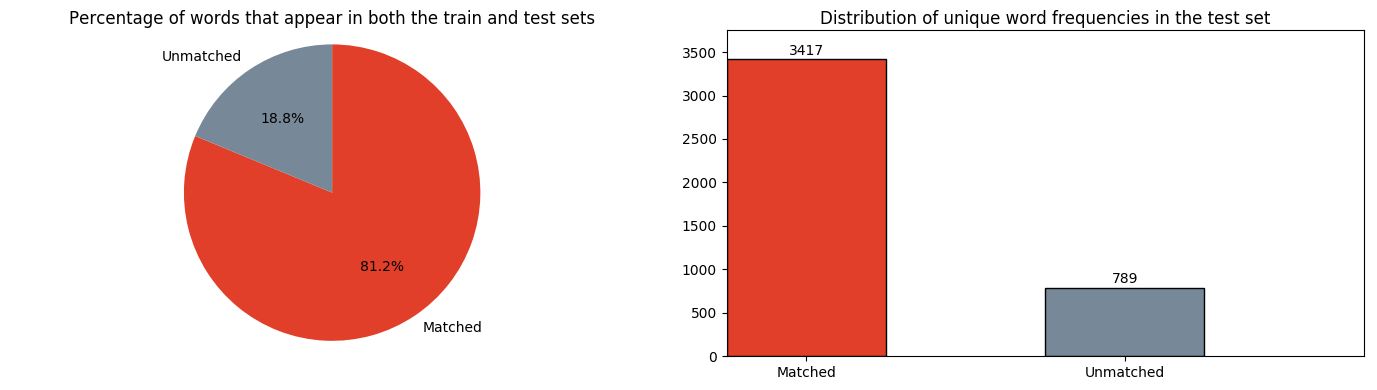

In [63]:
def autolabel_int(rects, ax):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height + 20,
                '%d' % int(height),
                ha='center', va='bottom')
        
def autolabel_percentage(rects, ax):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height + .02,
                '%.2f' % height,
                ha='center', va='bottom')

#create totals for charts
total = compare_counts_df.count()
matched = len(compare_counts_df[compare_counts_df['train_counts'].notnull()])
unmatched = len(compare_counts_df[compare_counts_df['train_counts'].isnull()])

#create figure with two subplots
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

labels = ['Matched','Unmatched']
colors = ["#E13F29",'lightslategray'] 

#Create pie chart for first subplot
ax1.pie([matched, unmatched], labels=labels, colors=colors, explode=(0,0),
    autopct='%1.1f%%', shadow=False, startangle=90, counterclock=False)
title = "Percentage of words that appear in both the train and test sets" 
ax1.set_title(title)
ax1.axis('equal')

#create bar chart for second subplot
y = [matched, unmatched] 
N = len(y)
x = np.arange(1,N+1)
width = 0.5

rects = ax2.bar(x, y, width, color=colors, edgecolor='black', linewidth=1, alpha=1.0)
ax2.set_title('Distribution of unique word frequencies in the test set')
ax2.set_xlim(1,N+1)
ax2.set_ylim(0, max(y)*1.1)
ax2.set_xticks(x + width/2.) #We need to use this to set the ticks in the middle of each bar
ax2.set_xticklabels(labels)
autolabel_int(rects, ax2)

plt.tight_layout()
plt.show()

Let's now determine how many of those unmatched words had their own row in the test dataset

In [64]:
#Create a Counter object to count the number of unique words in the test_data set where word_count = 1
results = Counter()
a = test_data[test_data['word_count']==1]['Phrase_clean'].str.lower()\
            .apply(lambda x: re.findall(r'(?u)\b\w\w+\b', x)) \
            .apply(results.update)

#Create a DataFrame from the Counter object
#Tell the DataFrame to create a new index for the data. Otherwise, the 'word' column will be the index of the DF
#Show a snippet of the results
test_results_1 = pd.DataFrame.from_dict(results, orient='index').reset_index()
test_results_1 = test_results_1.rename(columns={'index':'word', 0:'count'})
test_results_1.head()

,word,count
0,60s,1
1,tad,2
2,relying,1
3,continuity,1
4,meddles,1


The table above shows a wrinkle in the tokenization we performed for this analysis. In the source data every entry in the Phrase column was guaranteed to be unique. Now that we have tokenized by removing punctuation and single-character tokens we have duplicate values in our Phrase_clean column.

In [65]:
test_data[(test_data['Phrase_clean'].str.contains('baker')) & (test_data['word_count']==1)]

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_clean,word_count
154850,154851,8470,Baker 's,2,baker,1
154851,154852,8470,Baker,2,baker,1


In [66]:
#Compare new DataFrame to train results
compare_counts_1_df = pd.merge(test_results_1, train_results, how='left', on=['word'])
compare_counts_1_df = compare_counts_1_df.rename(columns={'count_x':'test_counts', 'count_y':'train_counts'})
print ("Number of records in test set where word_count = 1 that are not in the train set: ", \
       len(compare_counts_1_df[(compare_counts_1_df['train_counts'].isnull())]))

Number of records in test set where word_count = 1 that are not in the train set:  745
